# Spatially Sparse Precoding in Millimeter Wave MIMO Systems

In [1]:
import numpy as np
import matplotlib. pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #空间三维画图
import warnings
warnings.filterwarnings("ignore")

## mmWave MIMO Channel

$$\boldsymbol H = \frac {N_t N_r}{N_{cluster} N_{rai}} \sum_{i,l} α_{i,l} Λ_r(φ_{r,i,l}, θ_{r,i,l}) Λ_t(φ_{t,i,l}, θ_{t,i,l}) \boldsymbol a_r(φ_{r,i,l}, θ_{r,i,l}) \boldsymbol a_t(φ_{t,i,l}, θ_{t,i,l})^T$$
其中，
* $N_t$: Number of transmit antennas 
* $N_r$: Number of receive antennas
* $N_{cluster}$: Number of clusters
* $N_{ray}$: Number of rays per cluster
---
* $α_{i,l}$ 复信道增益, 对于$i^{th}$散射簇的$l^{th}$射线
* $\boldsymbol a_r(φ_{r,i,l}, θ_{r,i,l}),\ \boldsymbol a_t(φ_{t,i,l}, θ_{t,i,l})$ 阵列因子
    - 线阵天线: $\boldsymbol a_{ULA} (φ) = \frac{1}{\sqrt{N}} \left(1, ... , e^{jkd (n-1) \sin(φ)}, ... , e^{jkd (N-1) \sin(φ)}\right)^T$
    - 面阵天线: $\boldsymbol a_{UPA} (φ,θ) = \frac{1}{\sqrt{N}} \left(1, ... , e^{jkd ((m-1) \sin(φ) \sin(θ) + (n-1) cos(θ))}, ... , e^{jkd ((W-1) \sin(φ) \sin(θ) + (H-1) cos(θ))}\right)^T$
---
* $\theta_{Spread}$: Fixed angular spread at both the transmitter and receiver
* $\theta_{AoA}$

In [2]:
def mmWaveMIMOChannel(
    rangeAoD, rangeEoD, rangeAoA, rangeEoA,
    Nt, Nr, numCluster, numRay, angleSpread
):
    NtSum = Nt[0] * Nt[1]
    NrSum = Nr[0] * Nr[1]
    
    # Cluster Angle
    ClusterAoD = np.random.rand(numCluster) * (rangeAoD[1] - rangeAoD[0]) + rangeAoD[0]
    ClusterEoD = np.random.rand(numCluster) * (rangeEoD[1] - rangeEoD[0]) + rangeEoD[0]
    ClusterAoA = np.random.rand(numCluster) * (rangeAoA[1] - rangeAoA[0]) + rangeAoA[0]
    ClusterEoA = np.random.rand(numCluster) * (rangeEoA[1] - rangeEoA[0]) + rangeEoA[0]

    # rays angle per cluster
    b = angleSpread / np.sqrt(2);
    Randomness = np.random.rand(NumRay*NumCluster) - 0.5;

    RayAoD = np.repeat(ClusterAoD,numRay) - b*np.sign(Randomness) * np.log(1-2*abs(Randomness))
    RayEoD = np.repeat(ClusterEoD,numRay) - b*np.sign(Randomness) * np.log(1-2*abs(Randomness))
    RayAoA = np.repeat(ClusterAoA,numRay) - b*np.sign(Randomness) * np.log(1-2*abs(Randomness))
    RayEoA = np.repeat(ClusterEoA,numRay) - b*np.sign(Randomness) * np.log(1-2*abs(Randomness))

    # array response vectors
    [Y_Tx, Z_Tx] = np.meshgrid(np.arange(Nt[0]), np.arange(Nt[1])) 
    [Y_Rx, Z_Rx] = np.meshgrid(np.arange(Nr[0]), np.arange(Nr[1])) 
    
    PosTx = np.matrix([
        np.zeros(NtSum), 
        Y_Tx.reshape(NtSum), 
        Z_Tx.reshape(NtSum)
    ])
    
    PosRx = np.matrix([
        np.zeros(NrSum), 
        Y_Rx.reshape(NrSum), 
        Z_Rx.reshape(NrSum)
    ])


    sphericalUnitVecTx = np.matrix([np.sin(RayEoD)*np.cos(RayAoD), np.sin(RayEoD)*np.sin(RayAoD), np.cos(RayEoD)])
    sphericalUnitVecRx = np.matrix([np.sin(RayEoA)*np.cos(RayAoA), np.sin(RayEoA)*np.sin(RayAoA), np.cos(RayEoA)])

    arrayResponseTX = 1/np.sqrt(NtSum) * np.exp(1j*np.pi*PosTx.T * sphericalUnitVecTx)
    arrayResponseRX = 1/np.sqrt(NrSum) * np.exp(1j*np.pi*PosRx.T * sphericalUnitVecRx)

    # Generate MIMO channel matrix 
    alpha = np.sqrt(1/2)*(np.random.randn(numRay*numCluster) + 1j*np.random.randn(numRay*numCluster))
    channelMIMO = np.sqrt((NtSum*NrSum)/(numRay*numCluster))*arrayResponseRX  *np.diag(alpha) *arrayResponseTX.T

    return [channelMIMO,arrayResponseTX,arrayResponseRX,alpha]

Parameters

In [3]:
Nt = [8, 8]
Nr = [4, 4]
Ns = 1
NumRF = 4
NumCluster = 8
NumRay = 10
angleSpread = 7.5

# cluster angle
rangeAoD = [-np.pi/ 6, np.pi/ 6]
rangeEoD = [np.pi * (80 / 180), np.pi * (100/ 180)]
rangeAoA = [-np.pi, np.pi]
rangeEoA = [0, np.pi]

Test Result

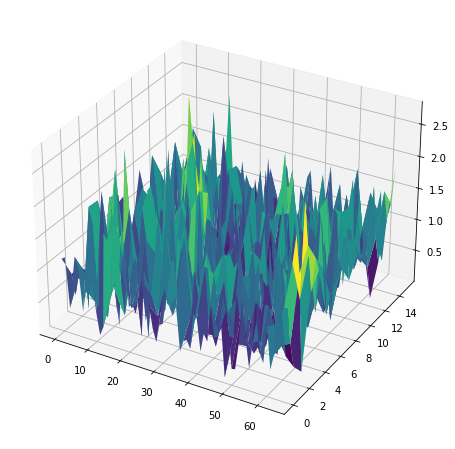

In [4]:
[H,arrayResponseTX,arrayResponseRX,alpha] = mmWaveMIMOChannel(
    rangeAoD, rangeEoD, rangeAoA, rangeEoA,
    Nt,Nr,NumCluster,NumRay,angleSpread
)

[X, Y] = np.meshgrid(np.arange(np.size(H,1)), np.arange(np.size(H,0))) 
fig = plt.figure(figsize = (8, 8))
ax  = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.abs(H),cmap='viridis', edgecolor='none')
plt.show()

## Spatially Sparse Precoding

* Optimal Precoding

\begin{align*}
    H &= U \Sigma V^H  \tag{SVD}\\
    F &= V(:,1:N_s) \\
    W_{MMSE} &= \frac{1}{\sqrt{\rho}} \left(F_{BB}^T F_{RF}^T H^T H F_{RF} F_{BB} + \frac{\sigma_n^2 N_s}{\rho} \boldsymbol I_{N_s}\right)^{-1} F_{BB}^T F_{RF}^T H^T
\end{align*}

---
* Spatially Sparse Precoding
    - Algorithm: Orthogonal Matching Prsuit 

In [5]:
def OptimalPrecoding(H, SNR, Ns):
    [U,S,V] = np.linalg.svd(H)
    F = np.matrix(V[:, 0:Ns])
    W = (1/np.sqrt(SNR) * np.linalg.inv(F.T * H.T * H * F + Ns/SNR * np.eye(Ns)) * (F.T * H.T)).T
    return [F, W]

In [6]:
def HybridSparsePrecoding(H, SNR, Ns, F_Opt, Nr, numRF, arrayResponseTX, arrayResponseRX):
    F_RF = []
    F_Res = F_Opt

    for r in range(numRF):
        Psi = arrayResponseTX.T*F_Res
        k = np.argmax(np.diag(Psi*Psi.T))

        if(r == 0):
            F_RF = arrayResponseTX[:,k]
        else:
            F_RF = np.hstack((F_RF, arrayResponseTX[:,k]))

        F_BB =  np.linalg.inv(F_RF.T * F_RF) * F_RF.T * F_Opt
        F_Res = (F_Opt-F_RF*F_BB) / np.linalg.norm(F_Opt-F_RF*F_BB,'fro')    

    F_BB = np.sqrt(Ns)*(F_BB/np.linalg.norm(F_RF*F_BB,'fro'))

    # Algorithm 2 - Hybrid combining
    CovRx = (SNR/Ns) * H * F_RF * F_BB * F_BB.T * F_RF.T *H.T + np.eye(Nr[0] * Nr[1])
    W_MMSE = (1/np.sqrt(SNR) * np.linalg.inv(F_BB.T*F_RF.T*H.T*H*F_RF*F_BB + (Ns/SNR)*np.eye(Ns))*(F_BB.T*F_RF.T*H.T)).T
    W_RF = []
    W_Res = W_MMSE

    for r in range(numRF):
        Psi = arrayResponseRX.T * CovRx * W_Res 
        k = np.argmax(np.diag(Psi * Psi.T))

        if(r == 0):
            W_RF = arrayResponseRX[:,k]
        else:
            W_RF = np.hstack((W_RF, arrayResponseRX[:,k]))

        W_BB = np.linalg.inv(W_RF.T*CovRx*W_RF) * W_RF.T*CovRx*W_MMSE 
        W_Res = (W_MMSE-W_RF*W_BB)/ np.linalg.norm(W_MMSE-W_RF*W_BB,'fro')
        
    return [F_RF, F_BB, W_RF, W_BB]

* Channel Capacity
\begin{align*}
C &= \log_2 \left(\left| I_{N_s} + \frac{\rho}{N_s} \boldsymbol R_N^{-1} (\boldsymbol W^H \boldsymbol H \boldsymbol F) (\boldsymbol W^H \boldsymbol H \boldsymbol F)^H \right|\right) \\
C &= \log_2 \left(\left| I_{N_s} + \frac{\rho}{N_s} \boldsymbol R_N^{-1} (\boldsymbol W_{BB}^H \boldsymbol W_{RF}^H \boldsymbol H \boldsymbol F_{RF} \boldsymbol F_{BB}) (\boldsymbol W_{BB}^H \boldsymbol W_{RF}^H \boldsymbol H \boldsymbol F_{RF} \boldsymbol F_{BB})^H \right|\right)
\end{align*}

In [7]:
 def ChannelCapacityMIMOPrecoding(H, F, W, SNR):
    Rn = W.T * W
    Tmp = W.T * H * F
    C = abs(np.log2(np.linalg.det(np.eye(Ns) + (SNR/Ns) * np.linalg.inv(Rn) * (Tmp * Tmp.T))))
    return C 

## Result of Paper

In [8]:
def Simulation( \
    Nt, Nr, Ns, numRF, numCluster, numRay, SNRDB, Iter
):
    spectralEfficiencyOptimal = np.zeros([Iter, np.size(SNRDB)]) 
    spectralEfficiencyHybrid  = np.zeros([Iter, np.size(SNRDB)]) 

    SNR = 10**(np.divide(SNRDB,10))

    # Precoding and combining algorithms
    for s in range(np.size(SNR)):
        for i in range(Iter):
            # H
            [H,arrayResponseTX,arrayResponseRX,_] = mmWaveMIMOChannel(
                rangeAoD, rangeEoD, rangeAoA, rangeEoA,
                Nt,Nr,numCluster,numRay,angleSpread
            )
            
            # Precoding
            [F_Opt, W_Opt] = OptimalPrecoding(H, SNR[s], Ns)
            [F_RF, F_BB, W_RF, W_BB] = HybridSparsePrecoding(H, SNR[s], Ns, F_Opt, Nr, numRF, arrayResponseTX, arrayResponseRX)

            # Spectial efficiency calculation 
            spectralEfficiencyOptimal[i,s] = ChannelCapacityMIMOPrecoding(H, F_Opt, W_Opt, SNR[s])
            spectralEfficiencyHybrid [i,s] = ChannelCapacityMIMOPrecoding(H, F_RF * F_BB, W_RF * W_BB, SNR[s]);

    spectralEfficiencyOptimal = np.mean(spectralEfficiencyOptimal,0)
    spectralEfficiencyHybrid  = np.mean(spectralEfficiencyHybrid,0) 
    return [spectralEfficiencyOptimal, spectralEfficiencyHybrid]

Parameters

In [9]:
SNRDB = range(-40,0,5)
Iter = 1000

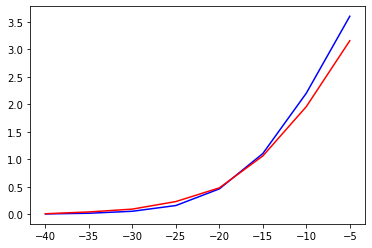

In [11]:
[spectralEfficiencyOptimal, spectralEfficiencyHybrid] = Simulation(Nt,Nr,Ns,NumRF,NumCluster,NumRay,SNRDB,Iter);
plt.plot(SNRDB, spectralEfficiencyOptimal, 'b')
plt.plot(SNRDB, spectralEfficiencyHybrid,  'r')